In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def run_query(query):
    conn = sqlite3.connect('chinook.db')
    return pd.read_sql(query, conn)

In [3]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
def show_tables():
    query = 'SELECT name,type FROM sqlite_master WHERE type IN ("table","view");'
    return run_query(query)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [6]:
#query for US sold tracks
q1 = " SELECT g.name genre, count(*) tracks_sold, cast (sum(il.quantity) as float)/cast ((select count(*) from invoice where i.billing_country = 'USA') as float)* 100 tracks_sold_pct FROM track t INNER JOIN invoice_line il ON il.track_id = t.track_id INNER JOIN invoice i ON i.invoice_id = il.invoice_id INNER JOIN genre g ON g.genre_id = t.genre_id WHERE i.billing_country = 'USA' group by 1 order by 2 desc"
run_query(q1)

,genre,tracks_sold,tracks_sold_pct
0,Rock,561,91.368078
1,Alternative & Punk,130,21.172638
2,Metal,124,20.195440
3,R&B/Soul,53,8.631922
4,Blues,36,5.863192
5,Alternative,35,5.700326
6,Latin,22,3.583062
7,Pop,22,3.583062
8,Hip Hop/Rap,20,3.257329
9,Jazz,14,2.280130


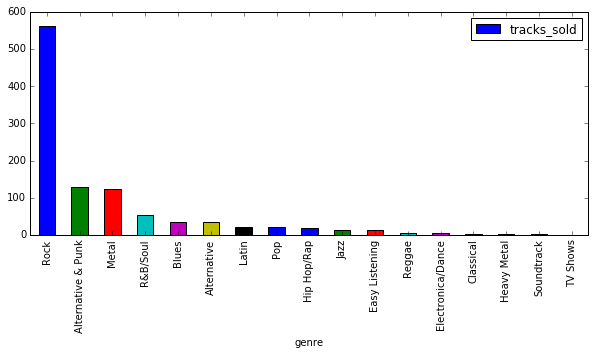

In [7]:
#plot to show the tracks sold by genre
genre_usa_sales = run_query(q1)
genre_usa_sales.plot.bar(x = 'genre', y = 'tracks_sold',figsize = (10,4))

We could see most of the sales here is from 3 genres -
1) Rock
2) Alternative and Punk
3) Metal

## Find the total dollar amount of sales assigned to each sales support agent within the company

For requested info, we need to know 1) total sales amount  2) Sales support agent(employee)
So we should most probably get info from 3 tables  - 1) employee
2)customer 3) invoice or invoice line

In [9]:
#Check total column that gives sale amount against invoice_id in invoice tanle 
q2 = "select * from invoice where invoice_id =1;"
run_query(q2)

,invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total
0,1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84


In [18]:
#Check total amount that gives sale amount against invoice_id in invoice_line tanle 
q3 = "select *, sum(unit_price*quantity) total from invoice_line group by invoice_id having invoice_id =1;"
run_query(q3)

,invoice_line_id,invoice_id,track_id,unit_price,quantity,total
0,16,1,1173,0.99,1,15.84


total column of invoice_line matche with that of amount in total column from invoice table.

In [38]:
q4 = "select c.support_rep_id , e.first_name || ' ' || e.last_name employee_name, sum(i.total) total_sales  from customer c inner join employee e on e.employee_id = c.support_rep_id inner join invoice i on i.customer_id = c.customer_id group by 1 order by 3 desc"
run_query(q4)

,support_rep_id,employee_name,total_sales
0,3,Jane Peacock,1731.51
1,4,Margaret Park,1584.00
2,5,Steve Johnson,1393.92


This gives the info of sales employees with total sales amount and we can say through sales amount not major differences in their sevices provided by them, hence if any particular employee is responsible for all sales

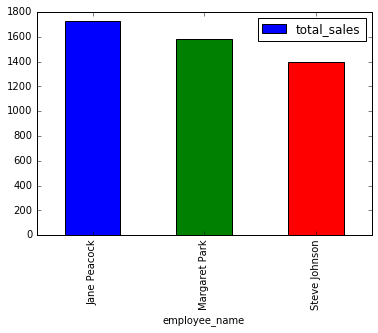

In [40]:
run_query(q4).plot.bar(x = 'employee_name', y = 'total_sales')

## Analyze the sales data for customers from each country

Required info -
1) total number of customers - will need details from customer table
2) total value of sales - can be obtained from invoice/invoice_line table
3) average value of sales per customer - can be obtained from invoice/invoice_line table and customer table
4) average order value - can be obtained from invoice/invoice_line table
5) countyry info - will need details from customer table/invoice table

In [52]:
#Find total number of customers in each country
# Lets join invoice with customer
q5 = "select count(customer_id) customers, country, customer_id from customer group by 2"
run_query(q5)

,customers,country,customer_id
0,1,Argentina,56
1,1,Australia,55
2,1,Austria,7
3,1,Belgium,8
4,5,Brazil,13
5,8,Canada,33
6,1,Chile,57
7,2,Czech Republic,6
8,1,Denmark,9
9,1,Finland,44


In [ ]:
# Lets try using WITH clause and Case to handle 'Other' group
WITH countries_others_sales AS
    (
        select CASE when (select count(*) from customer c where country = c.country ) =1 THEN 'Other' ELSE count(distinct customer_id) customers, country, customer_id from customer group by 2"

    )


In [65]:
q6 = 'SELECT count(customer_id) tot_customers, CASE WHEN (select count(customer_id) from customer c where country = c.country ) =1 THEN "Other" ELSE c.country END AS country from customer c group by 2 '
run_query(q6)

,tot_customers,country
0,1,Argentina
1,1,Australia
2,1,Austria
3,1,Belgium
4,5,Brazil
5,8,Canada
6,1,Chile
7,2,Czech Republic
8,1,Denmark
9,1,Finland


In [73]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


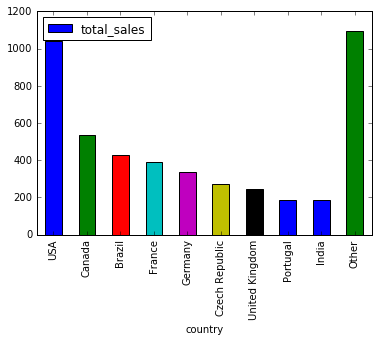

In [74]:
run_query(sales_by_country).plot.bar(x= 'country', y ='total_sales')

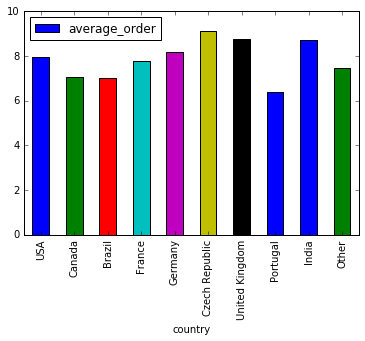

In [75]:
run_query(sales_by_country).plot.bar(x= 'country', y ='average_order')

Through visualization we can say that 'Other' group cannot be ignored as this itself makes max  total_sales as well as almost second max in making average order

Also we could see the average order is high in czech republic, united kingdom and India which makes them more potential for growth thus can be more focussed towards sales in these countries.

In [15]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) * 100 percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''
run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,81.433225
1,yes,114,18.566775


Over 81% of all purchases were not the “album only” choice and the company should definitely consider changing the strategy from above as the vast majority of customers prefer buying songs one by one instead of buying a whole album.